# Decision Trees (Random Forest and XGBoost)
by Cesar Malenab

### Declarations

In [283]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb

from yellowbrick.regressor import ResidualsPlot, PredictionError

from scipy.stats import uniform, randint

from joblib import dump, load

# Initialize JavaScript visualization for SHAP
shap.initjs()

# Set display options for pandas
pd.set_option('display.max_columns', None)

### Data Import

In [2]:
df = pd.read_csv('data/fire_resistance.csv')
df = df.set_index('beam_name')

In [3]:
df.head()

,length,concrete_area,concrete_cover,steel_area,frp_area,insulation_thickness,insulation_depth,conc_strength,steel_strength,frp_strength,glass_transition,thermal_conductivity,specific_heat,total_load,load_ratio,fire_resistance
beam_name,,,,,,,,,,,,,,,,
B1,3000,60000,25,402.1,0.0,0.0,0.0,47.6,591,0,0,0.000,0,61.2,44.8,90
B2,3000,60000,25,402.1,0.0,0.0,0.0,45.5,591,0,0,0.000,0,61.2,44.8,90
B3,3000,60000,25,402.1,120.0,25.0,0.0,44.4,591,2800,52,0.175,730800,81.2,38.4,76
B4,3000,60000,25,402.1,120.0,40.0,80.0,47.4,591,2800,52,0.175,730800,81.2,38.4,90
B5,3000,60000,25,402.1,120.0,25.0,80.0,45.1,591,2800,52,0.175,730800,81.2,38.4,92


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21434 entries, B1 to I5_ B4488
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   length                21434 non-null  int64  
 1   concrete_area         21434 non-null  int64  
 2   concrete_cover        21434 non-null  int64  
 3   steel_area            21434 non-null  float64
 4   frp_area              21434 non-null  float64
 5   insulation_thickness  21434 non-null  float64
 6   insulation_depth      21434 non-null  float64
 7   conc_strength         21434 non-null  float64
 8   steel_strength        21434 non-null  int64  
 9   frp_strength          21434 non-null  int64  
 10  glass_transition      21434 non-null  int64  
 11  thermal_conductivity  21434 non-null  float64
 12  specific_heat         21434 non-null  int64  
 13  total_load            21434 non-null  float64
 14  load_ratio            21434 non-null  float64
 15  fire_resistance    

### Train-test split

In [5]:
X = df.drop('fire_resistance', axis=1)
y = df['fire_resistance']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18218, 15)
(18218,)
(3216, 15)
(3216,)


## 1. Random Forest Regressor Model

### Initial base model:

In [8]:
rfr = RandomForestRegressor(n_estimators=10)

In [9]:
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

In [10]:
y_pred = rfr.predict(X_test)

RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
MAE = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {MAE}")
print(f"RMSE: {RMSE}")
print(f"r2: {r2}")

MAE: 11.50761815920398
RMSE: 20.349147900431404
r2: 0.9240769323339179


### Random search of best parameters

In [102]:
rfr = RandomForestRegressor()

In [103]:
param_dist = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'max_samples': [0.33, 0.66, 0.75, 0.99],
    'max_features': [2, 5, 8, 10, 12, 14],
    'max_depth': [10, 50, 100, None],
    'min_samples_split': [2, 6, 8, 10, 12, 15]
}

In [104]:
random_rfr = RandomizedSearchCV(estimator=rfr,
                                param_distributions=param_dist,
                                cv=5,
                                scoring='neg_mean_squared_error',
                                verbose=2,
                                n_iter=100,
                                random_state=42)

In [105]:
start_time = time.time()

random_rfr.fit(X_train, y_train)

duration = time.time() - start_time

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=10, max_features=10, max_samples=0.99, min_samples_split=12, n_estimators=200; total time=   6.0s
[CV] END max_depth=10, max_features=10, max_samples=0.99, min_samples_split=12, n_estimators=200; total time=   6.0s
[CV] END max_depth=10, max_features=10, max_samples=0.99, min_samples_split=12, n_estimators=200; total time=   6.0s
[CV] END max_depth=10, max_features=10, max_samples=0.99, min_samples_split=12, n_estimators=200; total time=   6.0s
[CV] END max_depth=10, max_features=10, max_samples=0.99, min_samples_split=12, n_estimators=200; total time=   6.0s
[CV] END max_depth=100, max_features=2, max_samples=0.33, min_samples_split=8, n_estimators=500; total time=   3.0s
[CV] END max_depth=100, max_features=2, max_samples=0.33, min_samples_split=8, n_estimators=500; total time=   3.1s
[CV] END max_depth=100, max_features=2, max_samples=0.33, min_samples_split=8, n_estimators=500; total time=   3.1s
[CV]

[CV] END max_depth=50, max_features=2, max_samples=0.99, min_samples_split=6, n_estimators=300; total time=   4.3s
[CV] END max_depth=50, max_features=2, max_samples=0.99, min_samples_split=6, n_estimators=300; total time=   4.2s
[CV] END max_depth=50, max_features=2, max_samples=0.99, min_samples_split=6, n_estimators=300; total time=   4.2s
[CV] END max_depth=50, max_features=2, max_samples=0.99, min_samples_split=6, n_estimators=300; total time=   4.2s
[CV] END max_depth=50, max_features=2, max_samples=0.99, min_samples_split=6, n_estimators=300; total time=   4.2s
[CV] END max_depth=50, max_features=2, max_samples=0.75, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END max_depth=50, max_features=2, max_samples=0.75, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END max_depth=50, max_features=2, max_samples=0.75, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END max_depth=50, max_features=2, max_samples=0.75, min_samples_split=2, n_

[CV] END max_depth=100, max_features=8, max_samples=0.75, min_samples_split=8, n_estimators=300; total time=   9.8s
[CV] END max_depth=100, max_features=8, max_samples=0.75, min_samples_split=8, n_estimators=300; total time=   9.8s
[CV] END max_depth=100, max_features=8, max_samples=0.75, min_samples_split=8, n_estimators=300; total time=   9.8s
[CV] END max_depth=100, max_features=8, max_samples=0.75, min_samples_split=8, n_estimators=300; total time=   9.7s
[CV] END max_depth=100, max_features=10, max_samples=0.99, min_samples_split=12, n_estimators=1000; total time=  43.9s
[CV] END max_depth=100, max_features=10, max_samples=0.99, min_samples_split=12, n_estimators=1000; total time=  44.2s
[CV] END max_depth=100, max_features=10, max_samples=0.99, min_samples_split=12, n_estimators=1000; total time=  44.3s
[CV] END max_depth=100, max_features=10, max_samples=0.99, min_samples_split=12, n_estimators=1000; total time=  44.2s
[CV] END max_depth=100, max_features=10, max_samples=0.99, m

[CV] END max_depth=50, max_features=14, max_samples=0.33, min_samples_split=2, n_estimators=200; total time=   7.1s
[CV] END max_depth=50, max_features=14, max_samples=0.33, min_samples_split=2, n_estimators=200; total time=   7.1s
[CV] END max_depth=50, max_features=14, max_samples=0.33, min_samples_split=2, n_estimators=200; total time=   7.1s
[CV] END max_depth=50, max_features=14, max_samples=0.33, min_samples_split=2, n_estimators=200; total time=   7.1s
[CV] END max_depth=None, max_features=5, max_samples=0.99, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END max_depth=None, max_features=5, max_samples=0.99, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END max_depth=None, max_features=5, max_samples=0.99, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END max_depth=None, max_features=5, max_samples=0.99, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END max_depth=None, max_features=5, max_samples=0.99, min_sampl

[CV] END max_depth=10, max_features=12, max_samples=0.75, min_samples_split=12, n_estimators=1000; total time=  31.9s
[CV] END max_depth=10, max_features=12, max_samples=0.75, min_samples_split=12, n_estimators=1000; total time=  31.9s
[CV] END max_depth=10, max_features=12, max_samples=0.75, min_samples_split=12, n_estimators=1000; total time=  32.1s
[CV] END max_depth=10, max_features=12, max_samples=0.75, min_samples_split=12, n_estimators=1000; total time=  31.9s
[CV] END max_depth=None, max_features=8, max_samples=0.75, min_samples_split=2, n_estimators=200; total time=   7.9s
[CV] END max_depth=None, max_features=8, max_samples=0.75, min_samples_split=2, n_estimators=200; total time=   7.8s
[CV] END max_depth=None, max_features=8, max_samples=0.75, min_samples_split=2, n_estimators=200; total time=   7.9s
[CV] END max_depth=None, max_features=8, max_samples=0.75, min_samples_split=2, n_estimators=200; total time=   7.9s
[CV] END max_depth=None, max_features=8, max_samples=0.75, m

[CV] END max_depth=50, max_features=2, max_samples=0.75, min_samples_split=6, n_estimators=1000; total time=  11.6s
[CV] END max_depth=50, max_features=2, max_samples=0.75, min_samples_split=6, n_estimators=1000; total time=  11.6s
[CV] END max_depth=50, max_features=2, max_samples=0.75, min_samples_split=6, n_estimators=1000; total time=  11.6s
[CV] END max_depth=50, max_features=2, max_samples=0.75, min_samples_split=6, n_estimators=1000; total time=  11.6s
[CV] END max_depth=10, max_features=5, max_samples=0.75, min_samples_split=10, n_estimators=200; total time=   2.9s
[CV] END max_depth=10, max_features=5, max_samples=0.75, min_samples_split=10, n_estimators=200; total time=   2.9s
[CV] END max_depth=10, max_features=5, max_samples=0.75, min_samples_split=10, n_estimators=200; total time=   2.9s
[CV] END max_depth=10, max_features=5, max_samples=0.75, min_samples_split=10, n_estimators=200; total time=   2.9s
[CV] END max_depth=10, max_features=5, max_samples=0.75, min_samples_spl

[CV] END max_depth=None, max_features=14, max_samples=0.99, min_samples_split=15, n_estimators=200; total time=  11.7s
[CV] END max_depth=None, max_features=14, max_samples=0.99, min_samples_split=15, n_estimators=200; total time=  11.6s
[CV] END max_depth=None, max_features=14, max_samples=0.99, min_samples_split=15, n_estimators=200; total time=  11.5s
[CV] END max_depth=None, max_features=12, max_samples=0.99, min_samples_split=10, n_estimators=1000; total time=  54.0s
[CV] END max_depth=None, max_features=12, max_samples=0.99, min_samples_split=10, n_estimators=1000; total time=  54.3s
[CV] END max_depth=None, max_features=12, max_samples=0.99, min_samples_split=10, n_estimators=1000; total time=  54.4s
[CV] END max_depth=None, max_features=12, max_samples=0.99, min_samples_split=10, n_estimators=1000; total time=  54.3s
[CV] END max_depth=None, max_features=12, max_samples=0.99, min_samples_split=10, n_estimators=1000; total time=  54.0s
[CV] END max_depth=10, max_features=5, max_

[CV] END max_depth=100, max_features=8, max_samples=0.75, min_samples_split=2, n_estimators=1000; total time=  38.6s
[CV] END max_depth=100, max_features=8, max_samples=0.75, min_samples_split=2, n_estimators=1000; total time=  38.5s
[CV] END max_depth=100, max_features=8, max_samples=0.66, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=100, max_features=8, max_samples=0.66, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=100, max_features=8, max_samples=0.66, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=100, max_features=8, max_samples=0.66, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END max_depth=100, max_features=8, max_samples=0.66, min_samples_split=2, n_estimators=100; total time=   3.5s


In [106]:
print(f"Training took {duration/60} minutes.")

Training took 98.7617491086324 minutes.


In [107]:
random_rfr.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'max_samples': 0.99,
 'max_features': 5,
 'max_depth': None}

In [108]:
random_rfr.best_estimator_

RandomForestRegressor(max_features=5, max_samples=0.99, n_estimators=300)

In [109]:
df_rfr = pd.DataFrame(random_rfr.cv_results_)

In [110]:
df_rfr.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_max_samples,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.031775,0.029261,0.064937,0.000679,200,12,0.99,10,10,"{'n_estimators': 200, 'min_samples_split': 12,...",-753.590143,-745.111032,-736.532778,-803.012400,-702.257108,-748.100692,32.526354,69
1,2.967339,0.018929,0.203451,0.001871,500,8,0.33,2,100,"{'n_estimators': 500, 'min_samples_split': 8, ...",-950.534599,-929.709092,-931.638464,-990.821371,-901.020036,-940.744712,29.618481,98
2,7.871409,0.074801,0.157846,0.001195,300,6,0.99,5,None,"{'n_estimators': 300, 'min_samples_split': 6, ...",-505.010868,-491.828905,-469.492279,-527.010708,-467.483812,-492.165314,22.372152,7
3,3.985508,0.017149,0.096135,0.001364,200,8,0.66,5,100,"{'n_estimators': 200, 'min_samples_split': 8, ...",-590.545149,-586.905737,-566.127519,-628.652419,-548.106959,-584.067556,27.028999,36
4,22.046781,0.067104,0.418904,0.001782,1000,8,0.33,10,50,"{'n_estimators': 1000, 'min_samples_split': 8,...",-722.936638,-701.358165,-680.775084,-761.787151,-672.901888,-707.951785,32.041650,60


In [111]:
y_preds = random_rfr.predict(X_test)

In [112]:
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
mae = mean_absolute_error(y_test, y_preds)

In [113]:
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 10.339196564301506
RMSE: 18.509063556464795


### Training with the best parameters:

In [18]:
rfr = RandomForestRegressor(n_estimators=300,
                           min_samples_split=2,
                           max_samples=0.99,
                           max_features=5,
                           max_depth=None)

In [19]:
rfr.fit(X_train, y_train)

RandomForestRegressor(max_features=5, max_samples=0.99, n_estimators=300)

In [63]:
y_pred = rfr.predict(X_test)

In [21]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
MAE = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {MAE}")
print(f"RMSE: {RMSE}")
print(f"r2: {r2}")

MAE: 10.332297868297402
RMSE: 18.576319186948336
r2: 0.9367295941578188


In [22]:
estimator = rfr.estimators_[0]

In [23]:
estimator.tree_.node_count

17413

In [24]:
estimator.tree_.max_depth

27

### Random Forest Prediction Error

C:\Anaconda\envs\cuda_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


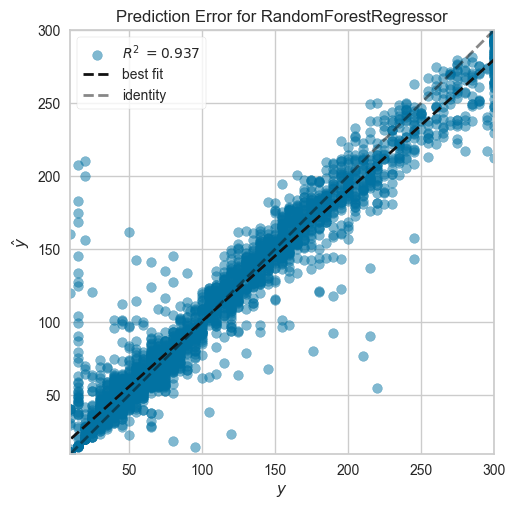

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [25]:
pe_visualizer = PredictionError(rfr, alpha=0.5)

pe_visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
pe_visualizer.score(X_test, y_test)  # Evaluate the model on the test data
pe_visualizer.show()  

### Random Forest Residual Plots

C:\Anaconda\envs\cuda_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


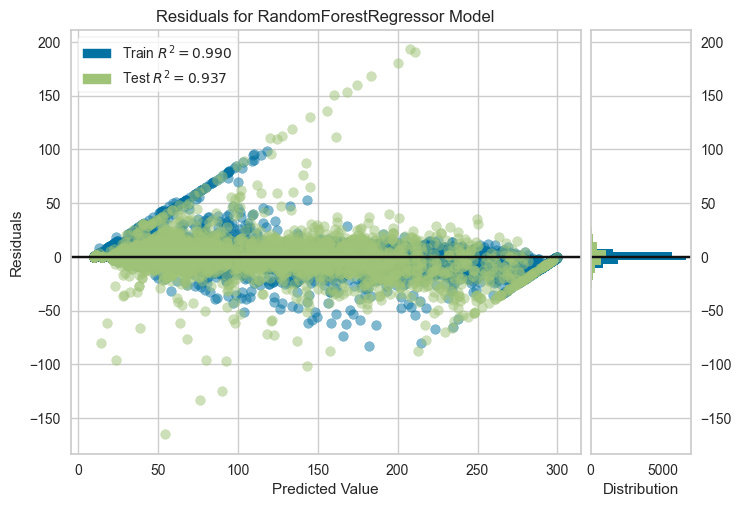

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [274]:
rp_visualizer = ResidualsPlot(rfr, train_alpha=0.5, test_alpha=0.5)

rp_visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
rp_visualizer.score(X_test, y_test)  # Evaluate the model on the test data
rp_visualizer.show()  

### Using SHAP for feature importance of Random Forest

In [272]:
explainer = shap.TreeExplainer(rfr)

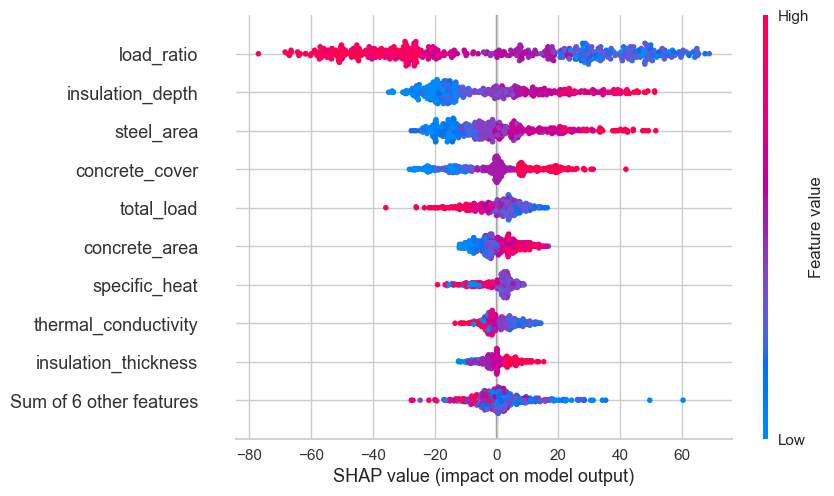

In [28]:
shap.plots.beeswarm(explainer(X_test[:500]))

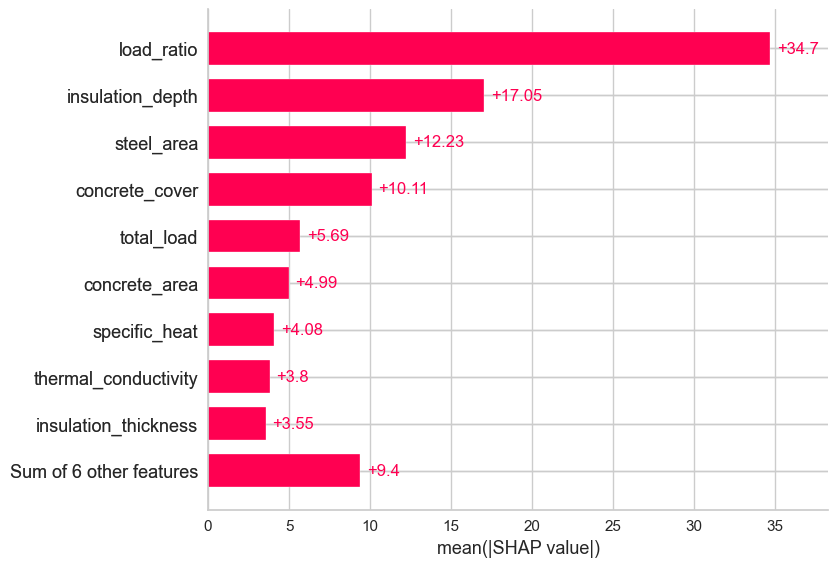

In [273]:
shap.plots.bar(explainer(X_test[:500]), max_display=10)

### Random Forest Model Prediction Errors

In [64]:
diff = np.abs(y_test - y_pred)

In [65]:
results_rfr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Absolute Difference': diff})\
.sort_values('Absolute Difference', ascending=False)

In [66]:
results_rfr.head(20)

,Actual,Predicted,Absolute Difference
beam_name,,,
I1_ B1303,15,207.916667,192.916667
I2_ B2620,20,210.683333,190.683333
I5_ B3988,20,200.483333,180.483333
I5_ B3088,15,183.216667,168.216667
I5_ B3983,220,54.750000,165.250000
I3_ B1774,15,174.600000,159.600000
I4_ B3901,15,168.450000,153.450000
I1_ B220,10,160.366667,150.366667
I4_ B4481,20,156.083333,136.083333


In [67]:
df.loc[results_rfr.index].head(20)

,length,concrete_area,concrete_cover,steel_area,frp_area,insulation_thickness,insulation_depth,conc_strength,steel_strength,frp_strength,glass_transition,thermal_conductivity,specific_heat,total_load,load_ratio,fire_resistance
beam_name,,,,,,,,,,,,,,,,
I1_ B1303,1640,105000,38,379.84,263.9,19.0,114.0,29.0,416,1034,83,0.145,523000,127.10,44.40,15
I2_ B2620,4820,105000,38,395.91,43.2,25.0,114.0,39.0,446,4100,84,0.111,962000,31.37,44.72,20
I5_ B3988,1660,122500,25,379.84,263.9,38.0,75.0,31.0,437,1068,85,0.198,312000,108.20,45.95,20
I5_ B3088,4040,157500,25,569.76,48.0,25.0,25.0,27.0,453,4100,73,0.190,300000,46.75,46.42,15
I5_ B3983,5480,122500,25,593.87,28.6,38.0,62.5,32.0,446,4318,77,0.188,297000,37.44,53.85,220
I3_ B1774,4740,157500,25,854.64,85.8,19.0,25.0,30.0,420,4123,73,0.044,334000,63.40,45.21,15
I4_ B3901,4740,105000,25,593.87,127.5,38.0,75.0,36.0,453,1138,87,0.084,384000,43.25,48.84,15
I1_ B220,5800,140000,38,569.76,0.0,0.0,0.0,32.0,421,0,0,0.000,0,20.19,45.71,10
I4_ B4481,4700,157500,38,569.76,116.0,38.0,114.0,37.0,420,966,83,0.090,410000,40.96,55.03,20


### Random Forest on experimental data

In [68]:
df_exp = df.head(50)

In [69]:
df_exp.head()

,length,concrete_area,concrete_cover,steel_area,frp_area,insulation_thickness,insulation_depth,conc_strength,steel_strength,frp_strength,glass_transition,thermal_conductivity,specific_heat,total_load,load_ratio,fire_resistance
beam_name,,,,,,,,,,,,,,,,
B1,3000,60000,25,402.1,0.0,0.0,0.0,47.6,591,0,0,0.000,0,61.2,44.8,90
B2,3000,60000,25,402.1,0.0,0.0,0.0,45.5,591,0,0,0.000,0,61.2,44.8,90
B3,3000,60000,25,402.1,120.0,25.0,0.0,44.4,591,2800,52,0.175,730800,81.2,38.4,76
B4,3000,60000,25,402.1,120.0,40.0,80.0,47.4,591,2800,52,0.175,730800,81.2,38.4,90
B5,3000,60000,25,402.1,120.0,25.0,80.0,45.1,591,2800,52,0.175,730800,81.2,38.4,92


In [70]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, B1 to B49
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   length                50 non-null     int64  
 1   concrete_area         50 non-null     int64  
 2   concrete_cover        50 non-null     int64  
 3   steel_area            50 non-null     float64
 4   frp_area              50 non-null     float64
 5   insulation_thickness  50 non-null     float64
 6   insulation_depth      50 non-null     float64
 7   conc_strength         50 non-null     float64
 8   steel_strength        50 non-null     int64  
 9   frp_strength          50 non-null     int64  
 10  glass_transition      50 non-null     int64  
 11  thermal_conductivity  50 non-null     float64
 12  specific_heat         50 non-null     int64  
 13  total_load            50 non-null     float64
 14  load_ratio            50 non-null     float64
 15  fire_resistance       50 non

In [71]:
X_exp = df_exp.drop('fire_resistance', axis=1)
y_exp = df_exp['fire_resistance']

X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_exp, y_exp, test_size=0.2, random_state=42)

In [72]:
print(X_train_exp.shape)
print(y_train_exp.shape)
print(X_test_exp.shape)
print(y_test_exp.shape)

(40, 15)
(40,)
(10, 15)
(10,)


Parameters from [Fire Performance of FRP-strengthened Concrete Flexural Members](https://d.lib.msu.edu/etd/50128):

**Random Forest Regressor**
* n_tree = 200
* m_try = 15
* unbounded decision trees
* 33% of total samples
* at least two samples for splitting nodes

In [74]:
rfr_exp = RandomForestRegressor(n_estimators=200,
                               max_samples=0.33,
                               max_features=15,
                               max_depth=None,
                               min_samples_split=2)

In [75]:
rfr_exp.fit(X_train_exp, y_train_exp)

y_preds_exp = rfr_exp.predict(X_test_exp)

rmse_exp = np.sqrt(mean_squared_error(y_test_exp, y_preds_exp))
mae_exp = mean_absolute_error(y_test_exp, y_preds_exp)

In [76]:
rmse_exp

33.10160011447919

In [77]:
mae_exp

26.347

In [78]:
r2_exp = r2_score(y_test_exp, y_preds_exp)

In [79]:
r2_exp

0.7899398163147715

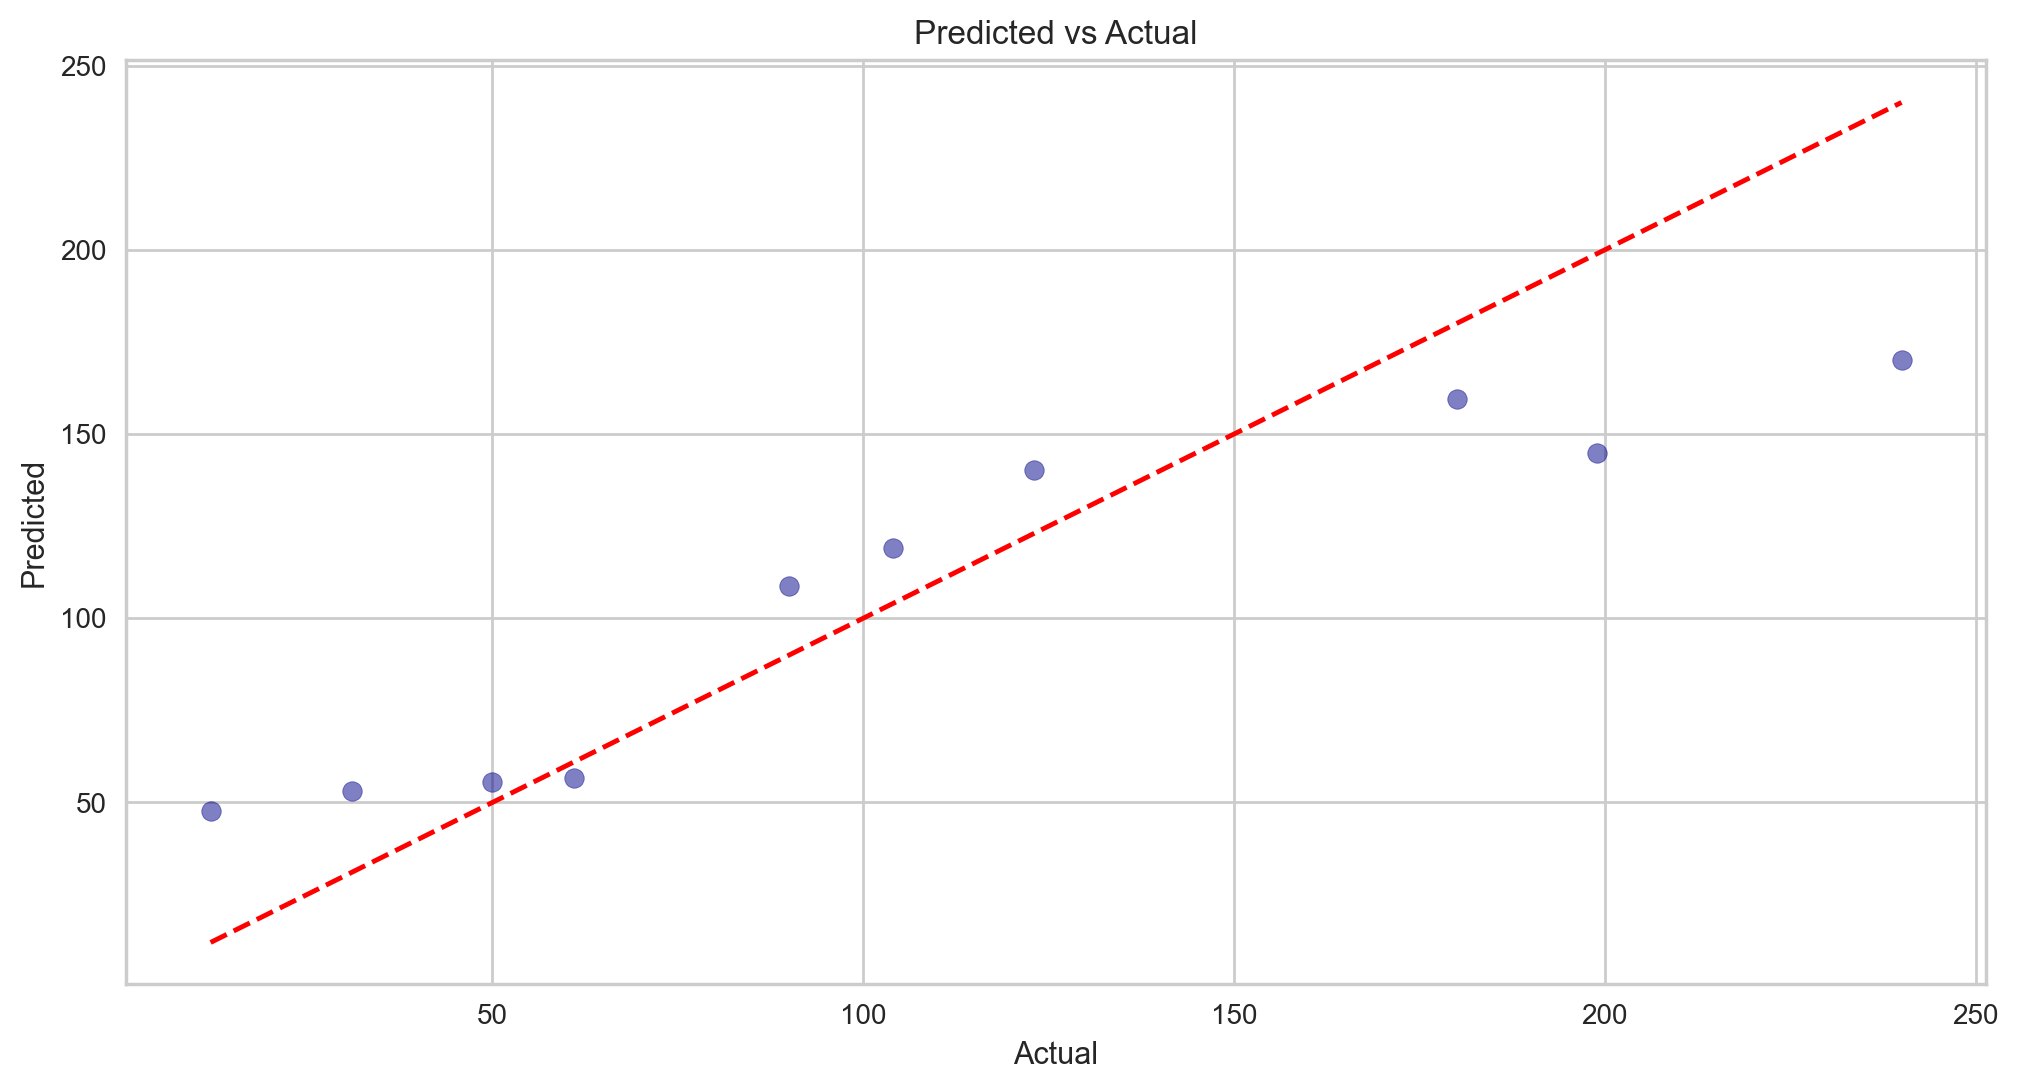

In [80]:
plt.figure(figsize=(12,6), dpi=200)
plt.scatter(y_test_exp, y_preds_exp, color='darkblue', alpha=0.5)
plt.plot([min(y_exp), max(y_exp)], [min(y_exp), max(y_exp)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()

---

## 2. Extreme Gradient Boosting (XGBoost)

In [38]:
xgb_model = xgb.XGBRegressor(max_depth=5,
                            n_estimators=200,
                            objective='reg:squarederror',
                            random_state=42,
                            learning_rate=0.1,
                            booster='gbtree')

### Initial base model:

In [39]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [40]:
y_pred = xgb_model.predict(X_test)

RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
MAE = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {MAE}")
print(f"RMSE: {RMSE}")
print(f"r2: {r2}")

MAE: 15.328355519935045
RMSE: 23.661060143596547
r2: 0.8973521896117358


### Random search of best parameters

In [44]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                              booster='gbtree',)

In [45]:
xgb_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [46]:
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma':uniform(1, 9),
    'reg_alpha':uniform(0, 5),
    'reg_lambda':uniform(0, 5),
}

In [47]:
random_xgb = RandomizedSearchCV(estimator=xgb_model,
                               param_distributions=param_dist,
                               n_iter=100,
                               cv=5,
                               scoring='neg_mean_squared_error',
                               random_state=42,
                               verbose=2)

In [48]:
random_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=0.6872700594236812, gamma=9.556428757689245, learning_rate=0.22959818254342154, max_depth=7, n_estimators=70, reg_alpha=0.7800932022121826, reg_lambda=0.7799726016810132, subsample=0.5290418060840998; total time=   0.1s
[CV] END colsample_bytree=0.6872700594236812, gamma=9.556428757689245, learning_rate=0.22959818254342154, max_depth=7, n_estimators=70, reg_alpha=0.7800932022121826, reg_lambda=0.7799726016810132, subsample=0.5290418060840998; total time=   0.1s
[CV] END colsample_bytree=0.6872700594236812, gamma=9.556428757689245, learning_rate=0.22959818254342154, max_depth=7, n_estimators=70, reg_alpha=0.7800932022121826, reg_lambda=0.7799726016810132, subsample=0.5290418060840998; total time=   0.1s
[CV] END colsample_bytree=0.6872700594236812, gamma=9.556428757689245, learning_rate=0.22959818254342154, max_depth=7, n_estimators=70, reg_alpha=0.7800932022121826, reg_lambda=0.7799726016810132, su

[CV] END colsample_bytree=0.831261142176991, gamma=3.8053996848046987, learning_rate=0.16602040635334325, max_depth=4, n_estimators=309, reg_alpha=0.9242722776276352, reg_lambda=4.847923138822793, subsample=0.8875664116805573; total time=   0.2s
[CV] END colsample_bytree=0.9697494707820946, gamma=9.053446153848839, learning_rate=0.18936999364332555, max_depth=6, n_estimators=239, reg_alpha=1.6266516538163218, reg_lambda=1.9433864484474102, subsample=0.6356745158869479; total time=   0.3s
[CV] END colsample_bytree=0.9697494707820946, gamma=9.053446153848839, learning_rate=0.18936999364332555, max_depth=6, n_estimators=239, reg_alpha=1.6266516538163218, reg_lambda=1.9433864484474102, subsample=0.6356745158869479; total time=   0.3s
[CV] END colsample_bytree=0.9697494707820946, gamma=9.053446153848839, learning_rate=0.18936999364332555, max_depth=6, n_estimators=239, reg_alpha=1.6266516538163218, reg_lambda=1.9433864484474102, subsample=0.6356745158869479; total time=   0.3s
[CV] END cols

[CV] END colsample_bytree=0.6008596011676981, gamma=9.061872361061674, learning_rate=0.15261106695463353, max_depth=7, n_estimators=145, reg_alpha=3.4775804321306376, reg_lambda=0.6966572720293784, subsample=0.8022086896389087; total time=   0.2s
[CV] END colsample_bytree=0.6008596011676981, gamma=9.061872361061674, learning_rate=0.15261106695463353, max_depth=7, n_estimators=145, reg_alpha=3.4775804321306376, reg_lambda=0.6966572720293784, subsample=0.8022086896389087; total time=   0.2s
[CV] END colsample_bytree=0.7699205456508366, gamma=2.8275510226129246, learning_rate=0.2928560711673943, max_depth=5, n_estimators=292, reg_alpha=0.8061064362700221, reg_lambda=4.648488261712865, subsample=0.9040601897822085; total time=   0.2s
[CV] END colsample_bytree=0.7699205456508366, gamma=2.8275510226129246, learning_rate=0.2928560711673943, max_depth=5, n_estimators=292, reg_alpha=0.8061064362700221, reg_lambda=4.648488261712865, subsample=0.9040601897822085; total time=   0.2s
[CV] END colsa

[CV] END colsample_bytree=0.6393232321183058, gamma=9.174392973699883, learning_rate=0.08186856720009172, max_depth=4, n_estimators=102, reg_alpha=2.447263801387815, reg_lambda=4.928252270553004, subsample=0.6210276357557503; total time=   0.0s
[CV] END colsample_bytree=0.6393232321183058, gamma=9.174392973699883, learning_rate=0.08186856720009172, max_depth=4, n_estimators=102, reg_alpha=2.447263801387815, reg_lambda=4.928252270553004, subsample=0.6210276357557503; total time=   0.0s
[CV] END colsample_bytree=0.8360677737029393, gamma=7.854576537958458, learning_rate=0.0812912631977199, max_depth=7, n_estimators=421, reg_alpha=4.917115704474215, reg_lambda=1.9941222122227653, subsample=0.908215936609692; total time=   0.8s
[CV] END colsample_bytree=0.8360677737029393, gamma=7.854576537958458, learning_rate=0.0812912631977199, max_depth=7, n_estimators=421, reg_alpha=4.917115704474215, reg_lambda=1.9941222122227653, subsample=0.908215936609692; total time=   0.8s
[CV] END colsample_byt

[CV] END colsample_bytree=0.8344941273571143, gamma=6.226179592928092, learning_rate=0.12168482996852292, max_depth=3, n_estimators=148, reg_alpha=4.8683191837765865, reg_lambda=1.4196048736873284, subsample=0.6526819301721967; total time=   0.0s
[CV] END colsample_bytree=0.8344941273571143, gamma=6.226179592928092, learning_rate=0.12168482996852292, max_depth=3, n_estimators=148, reg_alpha=4.8683191837765865, reg_lambda=1.4196048736873284, subsample=0.6526819301721967; total time=   0.0s
[CV] END colsample_bytree=0.7428068767931133, gamma=5.035817286876226, learning_rate=0.3083372387832462, max_depth=6, n_estimators=210, reg_alpha=0.09037681807760434, reg_lambda=2.469468575917173, subsample=0.5894113546106644; total time=   0.3s
[CV] END colsample_bytree=0.7428068767931133, gamma=5.035817286876226, learning_rate=0.3083372387832462, max_depth=6, n_estimators=210, reg_alpha=0.09037681807760434, reg_lambda=2.469468575917173, subsample=0.5894113546106644; total time=   0.3s
[CV] END colsa

[CV] END colsample_bytree=0.7784006312291751, gamma=9.425392967447028, learning_rate=0.2188089390024919, max_depth=4, n_estimators=337, reg_alpha=3.355717584120253, reg_lambda=1.7932339064808196, subsample=0.6270818245348694; total time=   0.2s
[CV] END colsample_bytree=0.7784006312291751, gamma=9.425392967447028, learning_rate=0.2188089390024919, max_depth=4, n_estimators=337, reg_alpha=3.355717584120253, reg_lambda=1.7932339064808196, subsample=0.6270818245348694; total time=   0.3s
[CV] END colsample_bytree=0.7784006312291751, gamma=9.425392967447028, learning_rate=0.2188089390024919, max_depth=4, n_estimators=337, reg_alpha=3.355717584120253, reg_lambda=1.7932339064808196, subsample=0.6270818245348694; total time=   0.2s
[CV] END colsample_bytree=0.6476452942094694, gamma=3.9029568781474047, learning_rate=0.26460093847740235, max_depth=3, n_estimators=348, reg_alpha=3.544554984550593, reg_lambda=2.764099884539539, subsample=0.6482550718238993; total time=   0.2s
[CV] END colsample_

[CV] END colsample_bytree=0.8975930973843518, gamma=3.437490261358668, learning_rate=0.14169142621169084, max_depth=4, n_estimators=278, reg_alpha=0.9216683716568502, reg_lambda=0.40436483308598836, subsample=0.7141572374700539; total time=   0.2s
[CV] END colsample_bytree=0.8975930973843518, gamma=3.437490261358668, learning_rate=0.14169142621169084, max_depth=4, n_estimators=278, reg_alpha=0.9216683716568502, reg_lambda=0.40436483308598836, subsample=0.7141572374700539; total time=   0.2s
[CV] END colsample_bytree=0.8975930973843518, gamma=3.437490261358668, learning_rate=0.14169142621169084, max_depth=4, n_estimators=278, reg_alpha=0.9216683716568502, reg_lambda=0.40436483308598836, subsample=0.7141572374700539; total time=   0.2s
[CV] END colsample_bytree=0.8975930973843518, gamma=3.437490261358668, learning_rate=0.14169142621169084, max_depth=4, n_estimators=278, reg_alpha=0.9216683716568502, reg_lambda=0.40436483308598836, subsample=0.7141572374700539; total time=   0.2s
[CV] END

[CV] END colsample_bytree=0.7866835208359666, gamma=2.156503179105192, learning_rate=0.25336125302080087, max_depth=5, n_estimators=150, reg_alpha=3.129698350507864, reg_lambda=4.1021342188563406, subsample=0.8257423859288939; total time=   0.1s
[CV] END colsample_bytree=0.7866835208359666, gamma=2.156503179105192, learning_rate=0.25336125302080087, max_depth=5, n_estimators=150, reg_alpha=3.129698350507864, reg_lambda=4.1021342188563406, subsample=0.8257423859288939; total time=   0.1s
[CV] END colsample_bytree=0.7866835208359666, gamma=2.156503179105192, learning_rate=0.25336125302080087, max_depth=5, n_estimators=150, reg_alpha=3.129698350507864, reg_lambda=4.1021342188563406, subsample=0.8257423859288939; total time=   0.1s
[CV] END colsample_bytree=0.7866835208359666, gamma=2.156503179105192, learning_rate=0.25336125302080087, max_depth=5, n_estimators=150, reg_alpha=3.129698350507864, reg_lambda=4.1021342188563406, subsample=0.8257423859288939; total time=   0.1s
[CV] END colsamp

[CV] END colsample_bytree=0.9750309835254025, gamma=9.555464322438006, learning_rate=0.18203136643698584, max_depth=7, n_estimators=118, reg_alpha=1.4660538584903227, reg_lambda=1.6433227268495798, subsample=0.8362592280385193; total time=   0.2s
[CV] END colsample_bytree=0.9750309835254025, gamma=9.555464322438006, learning_rate=0.18203136643698584, max_depth=7, n_estimators=118, reg_alpha=1.4660538584903227, reg_lambda=1.6433227268495798, subsample=0.8362592280385193; total time=   0.2s
[CV] END colsample_bytree=0.9750309835254025, gamma=9.555464322438006, learning_rate=0.18203136643698584, max_depth=7, n_estimators=118, reg_alpha=1.4660538584903227, reg_lambda=1.6433227268495798, subsample=0.8362592280385193; total time=   0.2s
[CV] END colsample_bytree=0.9750309835254025, gamma=9.555464322438006, learning_rate=0.18203136643698584, max_depth=7, n_estimators=118, reg_alpha=1.4660538584903227, reg_lambda=1.6433227268495798, subsample=0.8362592280385193; total time=   0.2s
[CV] END col

[CV] END colsample_bytree=0.5555987411530756, gamma=5.433625938617732, learning_rate=0.01340609343022572, max_depth=6, n_estimators=175, reg_alpha=0.28151637840918675, reg_lambda=0.5940895813403596, subsample=0.5587631233885524; total time=   0.2s
[CV] END colsample_bytree=0.8246051510580318, gamma=7.71440391338881, learning_rate=0.1850106295291479, max_depth=3, n_estimators=240, reg_alpha=2.3885744544011382, reg_lambda=0.4144566084667711, subsample=0.7641850606486046; total time=   0.1s
[CV] END colsample_bytree=0.8246051510580318, gamma=7.71440391338881, learning_rate=0.1850106295291479, max_depth=3, n_estimators=240, reg_alpha=2.3885744544011382, reg_lambda=0.4144566084667711, subsample=0.7641850606486046; total time=   0.1s
[CV] END colsample_bytree=0.8246051510580318, gamma=7.71440391338881, learning_rate=0.1850106295291479, max_depth=3, n_estimators=240, reg_alpha=2.3885744544011382, reg_lambda=0.4144566084667711, subsample=0.7641850606486046; total time=   0.1s
[CV] END colsampl

[CV] END colsample_bytree=0.5813084696724456, gamma=9.198344660444583, learning_rate=0.25676117287695066, max_depth=4, n_estimators=420, reg_alpha=3.6285975419418, reg_lambda=3.0670759796789495, subsample=0.7091215181453094; total time=   0.3s
[CV] END colsample_bytree=0.5813084696724456, gamma=9.198344660444583, learning_rate=0.25676117287695066, max_depth=4, n_estimators=420, reg_alpha=3.6285975419418, reg_lambda=3.0670759796789495, subsample=0.7091215181453094; total time=   0.3s
[CV] END colsample_bytree=0.9663642416770066, gamma=8.794575005503674, learning_rate=0.02356560103185682, max_depth=3, n_estimators=423, reg_alpha=4.052766653909164, reg_lambda=4.936380646574722, subsample=0.5752084455517641; total time=   0.2s
[CV] END colsample_bytree=0.9663642416770066, gamma=8.794575005503674, learning_rate=0.02356560103185682, max_depth=3, n_estimators=423, reg_alpha=4.052766653909164, reg_lambda=4.936380646574722, subsample=0.5752084455517641; total time=   0.2s
[CV] END colsample_byt

[CV] END colsample_bytree=0.794977948568818, gamma=5.320413703166276, learning_rate=0.13616073359952252, max_depth=7, n_estimators=390, reg_alpha=3.1968067848712116, reg_lambda=4.02522333759681, subsample=0.9515755293383131; total time=   0.7s
[CV] END colsample_bytree=0.794977948568818, gamma=5.320413703166276, learning_rate=0.13616073359952252, max_depth=7, n_estimators=390, reg_alpha=3.1968067848712116, reg_lambda=4.02522333759681, subsample=0.9515755293383131; total time=   0.7s
[CV] END colsample_bytree=0.794977948568818, gamma=5.320413703166276, learning_rate=0.13616073359952252, max_depth=7, n_estimators=390, reg_alpha=3.1968067848712116, reg_lambda=4.02522333759681, subsample=0.9515755293383131; total time=   0.7s
[CV] END colsample_bytree=0.8086318560486461, gamma=9.824164525831401, learning_rate=0.19242635486256557, max_depth=4, n_estimators=335, reg_alpha=2.7740780427111282, reg_lambda=0.4550104552566514, subsample=0.8631985163251141; total time=   0.2s
[CV] END colsample_by

[CV] END colsample_bytree=0.7517086354274285, gamma=7.213553457664288, learning_rate=0.021793641952329683, max_depth=3, n_estimators=96, reg_alpha=3.139501947454539, reg_lambda=0.40879515974435954, subsample=0.9367893120533886; total time=   0.0s
[CV] END colsample_bytree=0.7517086354274285, gamma=7.213553457664288, learning_rate=0.021793641952329683, max_depth=3, n_estimators=96, reg_alpha=3.139501947454539, reg_lambda=0.40879515974435954, subsample=0.9367893120533886; total time=   0.0s
[CV] END colsample_bytree=0.7517086354274285, gamma=7.213553457664288, learning_rate=0.021793641952329683, max_depth=3, n_estimators=96, reg_alpha=3.139501947454539, reg_lambda=0.40879515974435954, subsample=0.9367893120533886; total time=   0.0s
[CV] END colsample_bytree=0.7517086354274285, gamma=7.213553457664288, learning_rate=0.021793641952329683, max_depth=3, n_estimators=96, reg_alpha=3.139501947454539, reg_lambda=0.40879515974435954, subsample=0.9367893120533886; total time=   0.0s
[CV] END col

[CV] END colsample_bytree=0.7853891523344559, gamma=4.204870533080616, learning_rate=0.3059545746378939, max_depth=7, n_estimators=426, reg_alpha=1.1861339586799724, reg_lambda=0.5089123631020187, subsample=0.576429569592166; total time=   0.7s
[CV] END colsample_bytree=0.7853891523344559, gamma=4.204870533080616, learning_rate=0.3059545746378939, max_depth=7, n_estimators=426, reg_alpha=1.1861339586799724, reg_lambda=0.5089123631020187, subsample=0.576429569592166; total time=   0.7s
[CV] END colsample_bytree=0.7853891523344559, gamma=4.204870533080616, learning_rate=0.3059545746378939, max_depth=7, n_estimators=426, reg_alpha=1.1861339586799724, reg_lambda=0.5089123631020187, subsample=0.576429569592166; total time=   0.7s
[CV] END colsample_bytree=0.7853891523344559, gamma=4.204870533080616, learning_rate=0.3059545746378939, max_depth=7, n_estimators=426, reg_alpha=1.1861339586799724, reg_lambda=0.5089123631020187, subsample=0.576429569592166; total time=   0.7s
[CV] END colsample_b

[CV] END colsample_bytree=0.7978193703039221, gamma=5.244185696951425, learning_rate=0.13355227424418056, max_depth=3, n_estimators=118, reg_alpha=4.153097038938646, reg_lambda=4.825134553332563, subsample=0.5621486117427723; total time=   0.0s
[CV] END colsample_bytree=0.7978193703039221, gamma=5.244185696951425, learning_rate=0.13355227424418056, max_depth=3, n_estimators=118, reg_alpha=4.153097038938646, reg_lambda=4.825134553332563, subsample=0.5621486117427723; total time=   0.0s
[CV] END colsample_bytree=0.7978193703039221, gamma=5.244185696951425, learning_rate=0.13355227424418056, max_depth=3, n_estimators=118, reg_alpha=4.153097038938646, reg_lambda=4.825134553332563, subsample=0.5621486117427723; total time=   0.0s
[CV] END colsample_bytree=0.7978193703039221, gamma=5.244185696951425, learning_rate=0.13355227424418056, max_depth=3, n_estimators=118, reg_alpha=4.153097038938646, reg_lambda=4.825134553332563, subsample=0.5621486117427723; total time=   0.0s
[CV] END colsample_b

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster='gbtree',
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_r...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000017E37858970>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000017E37877760>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000017E37759E10>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000017E37877070>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [49]:
random_xgb.best_params_

{'colsample_bytree': 0.794977948568818,
 'gamma': 5.320413703166276,
 'learning_rate': 0.13616073359952252,
 'max_depth': 7,
 'n_estimators': 390,
 'reg_alpha': 3.1968067848712116,
 'reg_lambda': 4.02522333759681,
 'subsample': 0.9515755293383131}

In [50]:
y_pred = random_xgb.predict(X_test)

In [51]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
MAE = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {MAE}")
print(f"RMSE: {RMSE}")
print(f"r2: {r2}")

MAE: 9.644103147793764
RMSE: 17.67238038825745
r2: 0.9427373565666307


### Training on best parameters:

In [52]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                              booster='gbtree',
                              max_depth=7,
                              n_estimators=400,
                              colsample_bytree=0.8,
                              subsample=0.95,
                              learning_rate=0.1,
                              gamma=5,
                              reg_alpha=3,
                              reg_lambda=4,)

In [53]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [54]:
y_pred = xgb_model.predict(X_test)

RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
MAE = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {MAE}")
print(f"RMSE: {RMSE}")
print(f"r2: {r2}")

MAE: 9.866703238653306
RMSE: 17.82361538062786
r2: 0.9417530895237072


### XGBoost Residual Plots

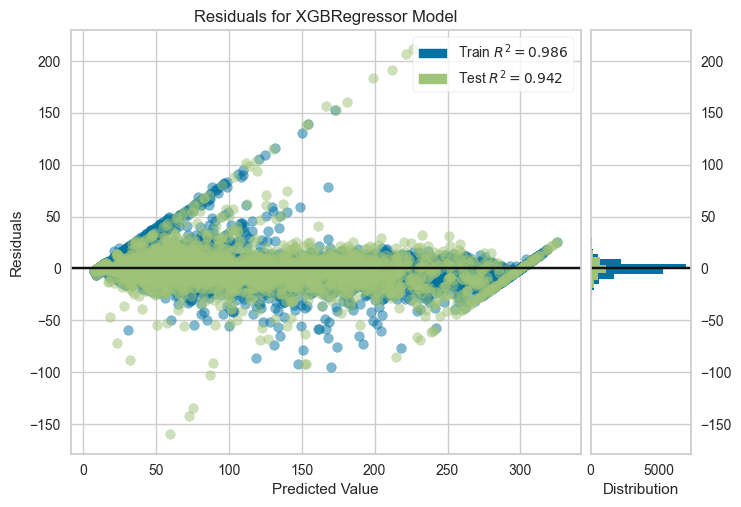

<Axes: title={'center': 'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [55]:
rp_visualizer = ResidualsPlot(xgb_model, train_alpha=0.5, test_alpha=0.5)

rp_visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
rp_visualizer.score(X_test, y_test)  # Evaluate the model on the test data
rp_visualizer.show()  

### XGBoost Prediction Error

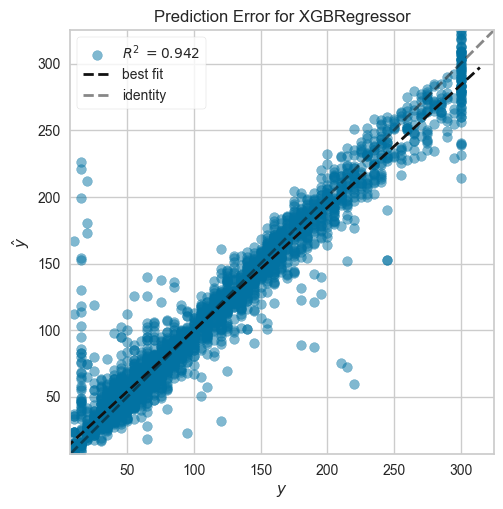

<Axes: title={'center': 'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [56]:
pe_visualizer = PredictionError(xgb_model, alpha=0.5)

pe_visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
pe_visualizer.score(X_test, y_test)  # Evaluate the model on the test data
pe_visualizer.show()  

### Using SHAP for feature importance of XGBoost

In [60]:
explainer = shap.TreeExplainer(xgb_model)

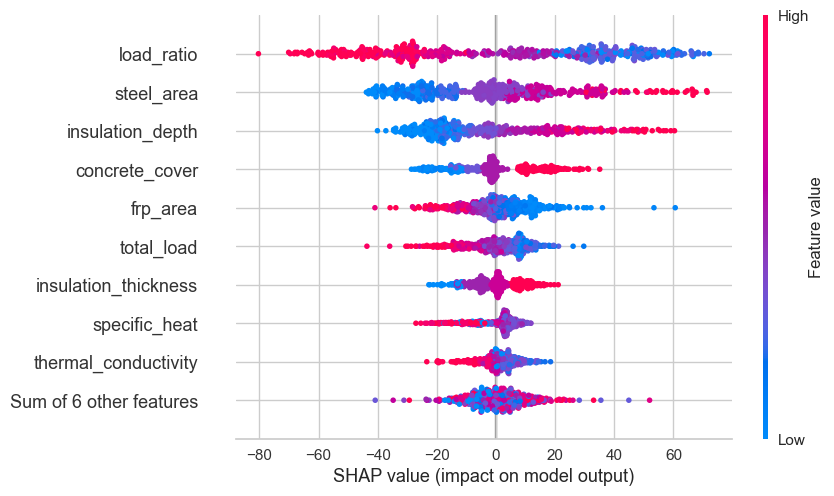

In [61]:
shap.plots.beeswarm(explainer(X_test[:500]))

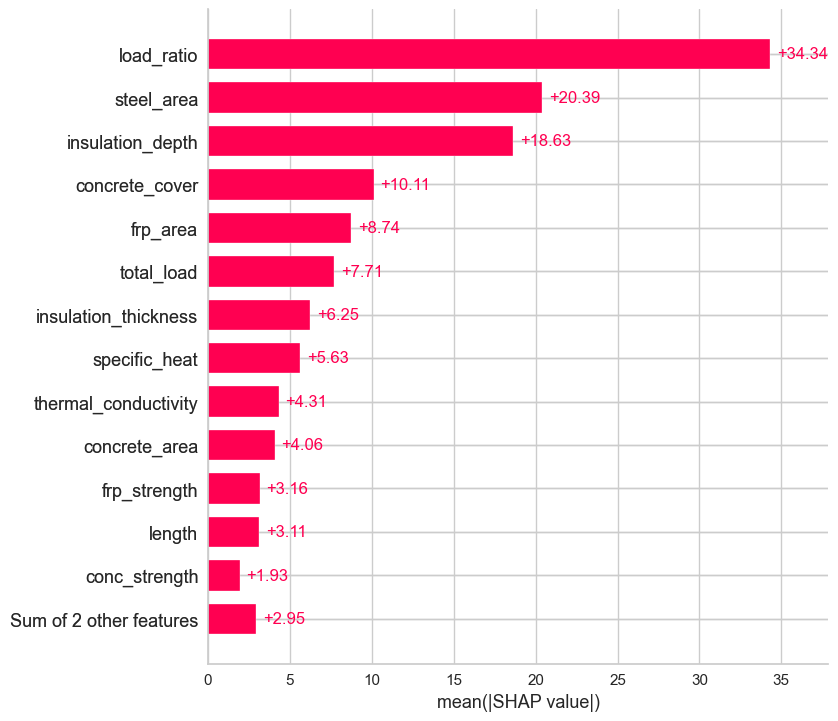

In [62]:
shap.plots.bar(explainer(X_test[:500]), max_display=14)

### XGBoost Model Prediction Errors

In [86]:
y_pred

array([ 32.25      , 202.56666667, 197.18333333, ..., 153.26333333,
        79.9       ,  72.11666667])

In [250]:
#Absolute difference
abs_diff = np.abs(y_test - y_pred)

results_rfr_abs = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Absolute Difference': abs_diff})\
.sort_values('Absolute Difference', ascending=False)

In [281]:
results_rfr_abs.head(10)

,Actual,Predicted,Absolute Difference
beam_name,,,
I1_ B1303,15,207.916667,192.916667
I2_ B2620,20,210.683333,190.683333
I5_ B3988,20,200.483333,180.483333
I5_ B3088,15,183.216667,168.216667
I5_ B3983,220,54.750000,165.250000
I3_ B1774,15,174.600000,159.600000
I4_ B3901,15,168.450000,153.450000
I1_ B220,10,160.366667,150.366667
I4_ B4481,20,156.083333,136.083333


Text(0.5, 0, 'Actual Fire Resistance')

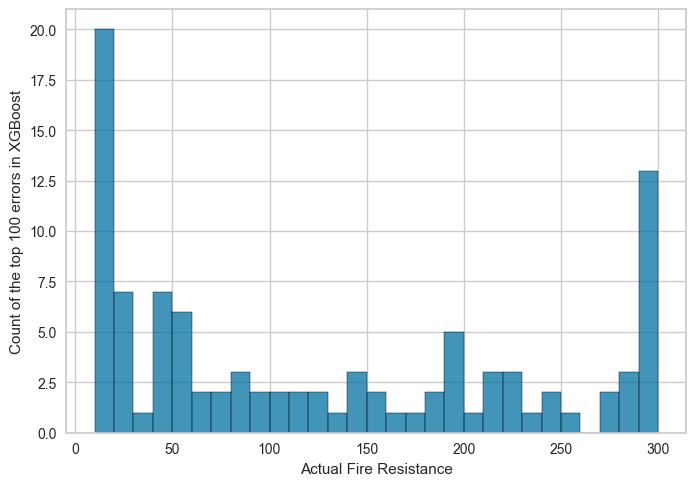

In [280]:
sns.histplot(data=results_rfr_abs.iloc[:100],
             x='Actual',
            binwidth=10)

ax = plt.gca()
ax.set_ylabel('Count of the top 100 errors in XGBoost')
ax.set_xlabel('Actual Fire Resistance')

---